In [1]:
import numpy
import hmclab

# Ray tracing in horizontally layered media 

## Ray tracer


This notebook serves as an introduction on to the usage of a Ray Tracer buitl for horizontally layered models. It does not solve for start and end point; it computes a ray for start point and take-off angle. It computes these rays until:
1. The ray bottoms out and becomes upgoing;
2. The ray passes the last layer (and has no chance of turning around);
3. The ray passes a line of receivers.

Note that (1.) is optional, and rays can be traced upwards as well. We later demonstrate why this for our purposes is undesireable.

Let's start by **first** creating the receivers out at a distance of 500 meters from the source, with a bunch of them spaced evenly along a vertical profile. Additionally, we add "layers" amount of layers (40 when this notebook was made), and **subsequently** compute at what depth the layer interfaces are. Adding more layers makes computing the rays in this notebook more expensive, as more refractions have to be calculated. **Finally**, we create evenly spaced take-off angles to compute rays for.

In [2]:
n_layers = 40

layer_interfaces =  numpy.linspace(0, 1000, n_layers) + 20
shot_distances = [500]
receiver_depths =  numpy.linspace(100, 800, 28)

physics = hmclab.Distributions.LayeredRayTracing2D(layer_interfaces, shot_distances,receiver_depths)

angles = numpy.linspace(0, 89, 350)

Our ray solver is wrapped in a nice plotting function (`plot_rays_and_model`), so we don't have to repeat ourselves much. It will also visualize the velocity model we still have to create. Let's start by a simple velocity gradient in depth:

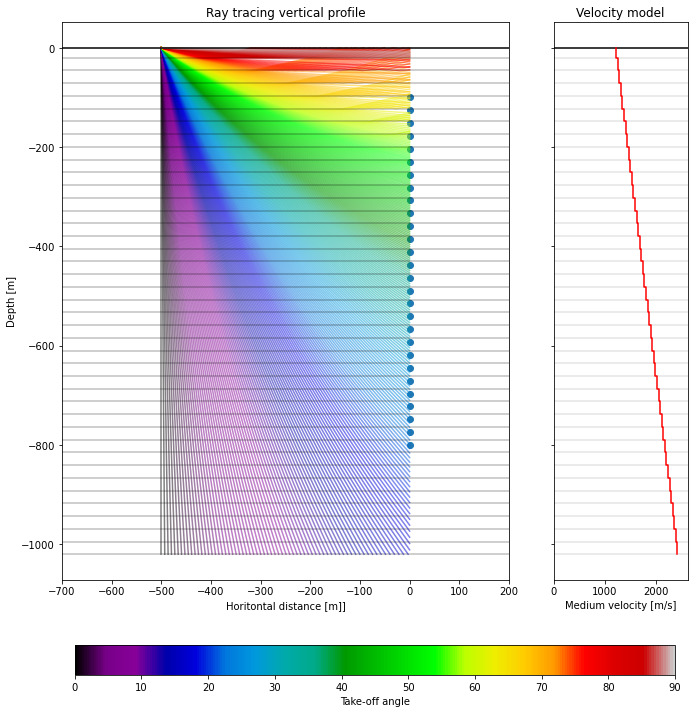

In [3]:
velocities_1 = numpy.ones_like(physics.layer_interfaces) * 1200 + physics.layer_interfaces * 1.2

_ = physics.plot_rays(angles, velocities_1)

Wonderful. We see that most rays in this plot (coloured according to their take-off angle) actuallydon't refract much; i.e. the take-off angles at e.g. 45 degrees still propagate close to the take-off angle deeper in our model. Refraction is present, but not overly strong.

Let us bump this a bit by introducing a low velocity layer at the very surface.

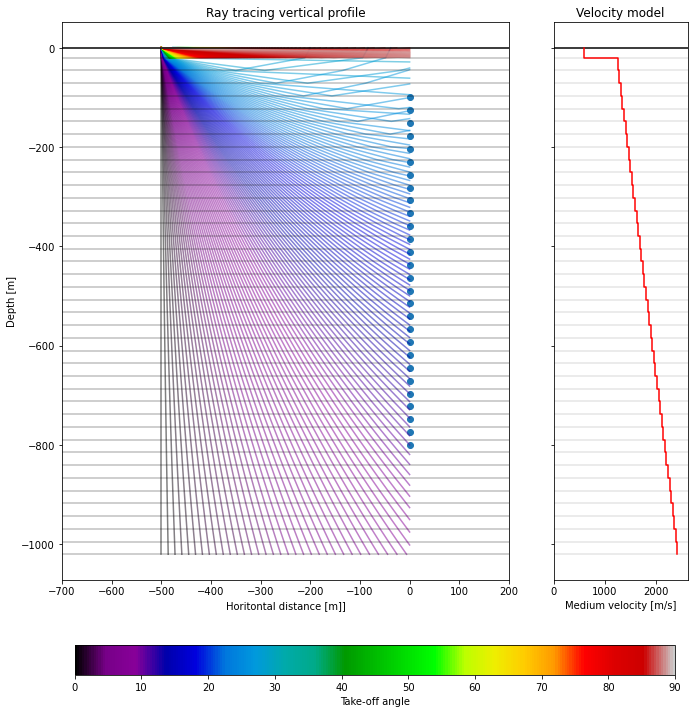

In [4]:
velocities_2 = velocities_1.copy()
velocities_2[0] = 600

_ = physics.plot_rays(angles, velocities_2)

We can now see that many of the rays stay trapped in the top layer. Only the range of take-off angles between 0-30 propagate further into the surface, and they fan out to span the entire ray parameter range below this. We start to see the first signs of rays bottoming out.

We see as well as the limitation of using the linearly spaced take-off angles: the range around take-off angle 25 degrees becomes a highly important part of the plot, as these rays are refracted over a wide range of angles. Adding more angles around 25 degrees would increase the quality of the ray tracing in the first layers below the low velocity layer.

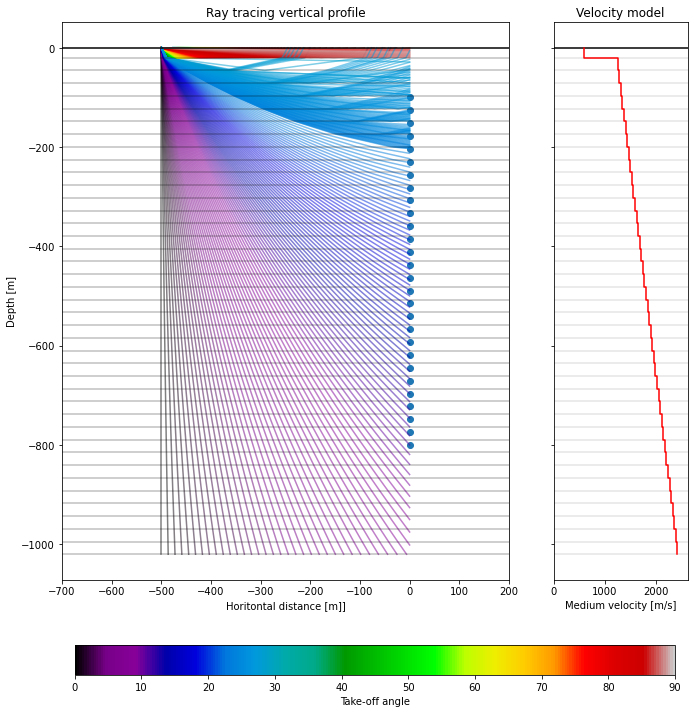

In [5]:
angles_augmented = numpy.append(angles, numpy.linspace(24,28,100))

_ = physics.plot_rays(angles_augmented, velocities_2)

Let's have a final look at a more intricate model. We now add random velocity changes to the layers of the model, hopefully yielding more complex rays. 

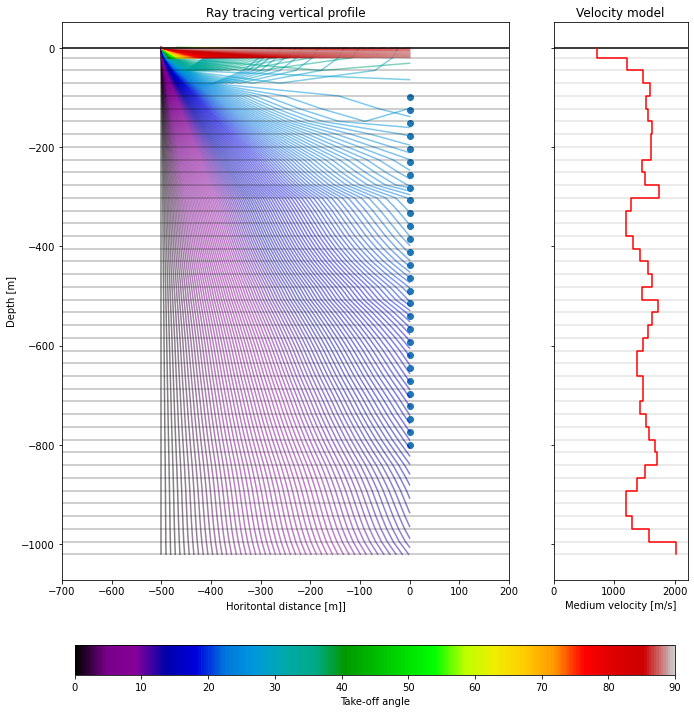

In [6]:
from scipy.signal import savgol_filter

noise = 300 * savgol_filter(
    numpy.random.randn(n_layers), 8, 3
)  # window size 51, polynomial order 3

# interfaces = numpy.linspace(0, 1000**(1/1.3), layers)**1.3+10
velocities_complex = (
    numpy.ones(n_layers) * 1800
    + noise
    + layer_interfaces * 0.5
    - 600
    - 400 * numpy.exp(-(((layer_interfaces - 500) / 20) ** 2))
    + 400 * numpy.exp(-(((layer_interfaces - 300) / 20) ** 2)) 
    - 200 * numpy.exp(-(layer_interfaces-15)/ 20)
)


_ = physics.plot_rays(angles, velocities_complex)

Here we can see how high velocity layers cause significant upgoing waves. This makes solving for a stable ray with fixed source and receiver much harder. To mitigate this, we only consider downgoing waves in the following notebooks. The ray tracing is therefore terminated as soon as a ray tries to pass an interface while upgoing. This alters typical rays as seen in the following ray tracing plot.

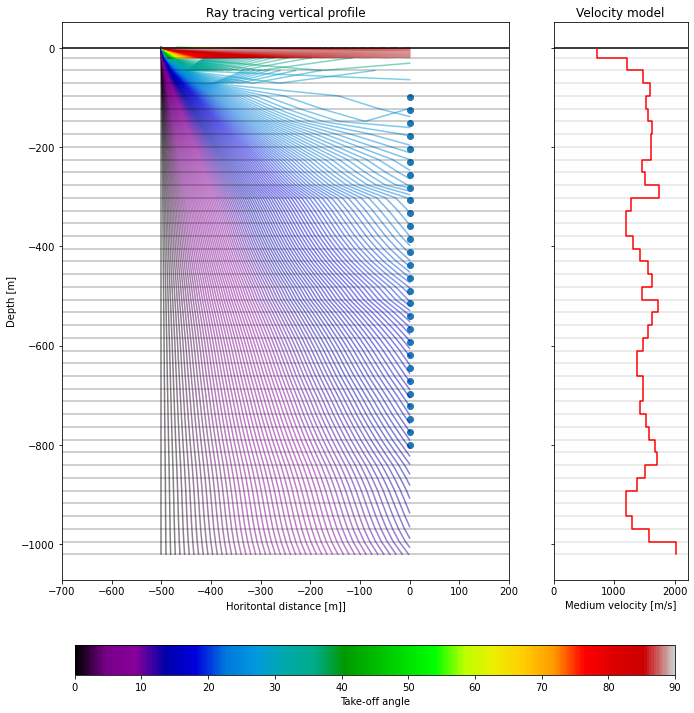

In [7]:
_ = physics.plot_rays(angles, velocities_complex, keep_upgoing=False)

## Ray-solving algorithm

In [8]:

tolerance = 2.0


CPU times: user 72.7 ms, sys: 26.2 ms, total: 98.9 ms
Wall time: 103 ms


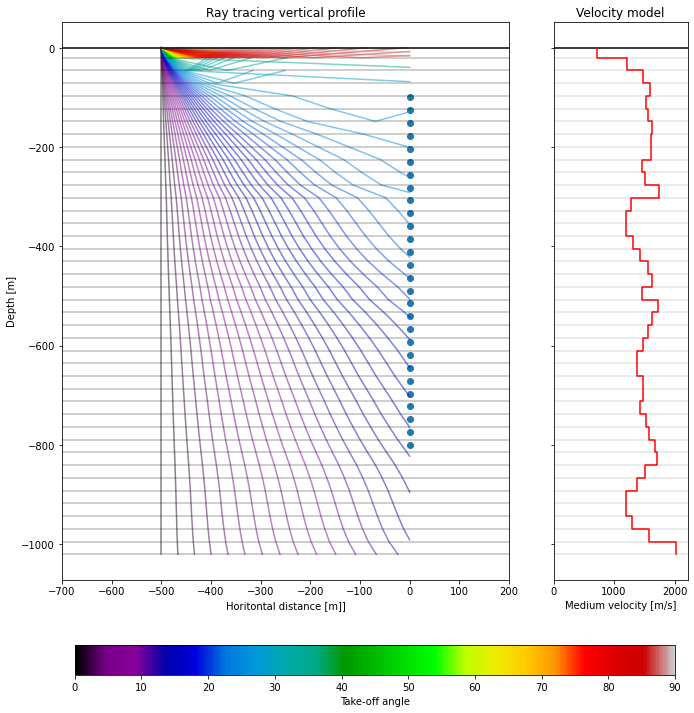

In [9]:
%%time

angles= numpy.linspace(0, 89.9, 100)

_ = physics.plot_rays(angles, velocities_complex, keep_upgoing=False)

In [10]:
# from hmclab.Distributions.LayeredRayTracing2D import  _search_angles


In [11]:
%%time

angles_first_solve, traveltimes, lt = physics.search_angles(
    velocities_complex,
    angles=50,
    randomize_angle_fraction=.1,
    max_attempts=15,
    verbose=False,
)

Found: 28 / 28 receivers.
CPU times: user 1.7 s, sys: 3.24 s, total: 4.93 s
Wall time: 6.01 s


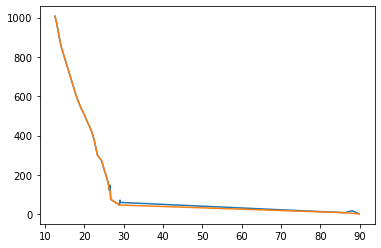

In [12]:
import matplotlib.pyplot as plt, numpy as _numpy
plt.plot(lt[:,0], lt[:,1])

a_cummax = _numpy.minimum.accumulate(lt[:,1])    
a_new, idx = _numpy.unique(a_cummax, return_index=True)
plt.plot(lt[idx, 0], a_new)


In [13]:
%%time

angles_second_solve, traveltimes, _ = physics.search_angles(
    velocities_complex,
    angles=angles_first_solve,
    randomize_angle_fraction=.1,
    max_attempts=15,
    verbose=False
)

Found: 28 / 28 receivers.
CPU times: user 31.5 ms, sys: 34.8 ms, total: 66.3 ms
Wall time: 71.3 ms


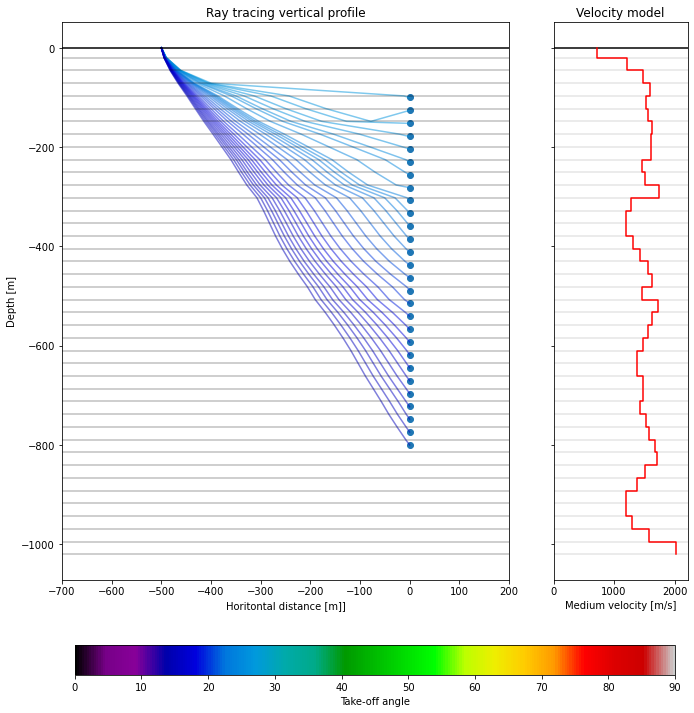

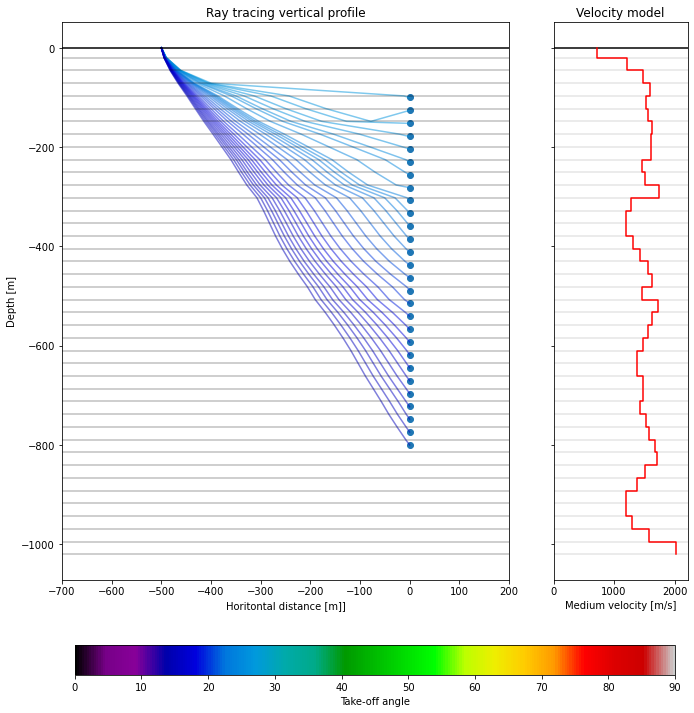

In [14]:
_ = physics.plot_rays(angles_first_solve, velocities_complex, keep_upgoing=False)
_ = physics.plot_rays(angles_second_solve, velocities_complex, keep_upgoing=False)

## Fitting some observations

In [15]:
import pandas, matplotlib.pyplot as plt

tts = pandas.read_csv("./raytomography/traveltimes.csv",header=None)

shot_distances = [42.8]
receiver_depths = tts[0].to_numpy()

receiver_distances = (shot_distances[0]**2 + receiver_depths**2)**0.5

arrival_times_observed= tts[1].to_numpy()

nonnan = numpy.logical_not(numpy.isnan(arrival_times_observed))

receiver_depths = receiver_depths[nonnan]
receiver_distances = receiver_distances[nonnan]
arrival_times_observed=arrival_times_observed[nonnan]

In [16]:
A = numpy.array([receiver_distances, numpy.ones_like(receiver_distances)]).T
b = arrival_times_observed

best_fit = numpy.linalg.lstsq(A, b, rcond=-1)

approximate_speed = (1.0 / best_fit[0][0]).item()
approximate_origin_time = ( best_fit[0][1]).item()

print(f"Approximate medium velocity:\t{approximate_speed:.2f}"
      f"m/s\r\nApproximate origin time:\t{approximate_origin_time:.2f} s")

Approximate medium velocity:	3809.62m/s
Approximate origin time:	0.10 s


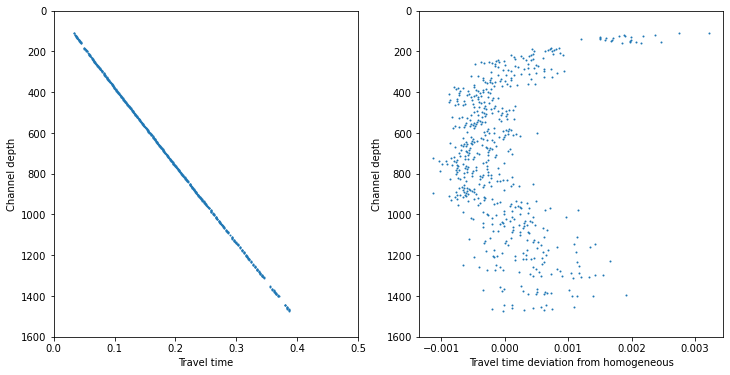

In [17]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(
    arrival_times_observed-approximate_origin_time, 
    receiver_depths, s=1)
plt.gca().yaxis
plt.xlim([0,0.5])
plt.ylim([0,1600])
plt.xlabel("Travel time")
plt.ylabel("Channel depth")
plt.gca().invert_yaxis()
plt.subplot(122)
plt.scatter(
    arrival_times_observed-approximate_origin_time - receiver_distances/approximate_speed, 
    receiver_depths, s=1)
plt.gca().yaxis
plt.ylim([0,1600])
plt.xlabel("Travel time deviation from homogeneous")
plt.ylabel("Channel depth")
plt.gca().invert_yaxis()


In [18]:
layers = 63

# For exponential layer thickness, use alpha>1
alpha=1.0
layer_interfaces = numpy.linspace(0, 1550**(1/alpha), layers)**alpha 
layer_interfaces += layer_interfaces[-1] - layer_interfaces[-2]


physics = hmclab.Distributions.LayeredRayTracing2D(layer_interfaces, shot_distances,receiver_depths)

physics.tolerance = 1.0
velocities = (
    numpy.ones(layers) * approximate_speed
)


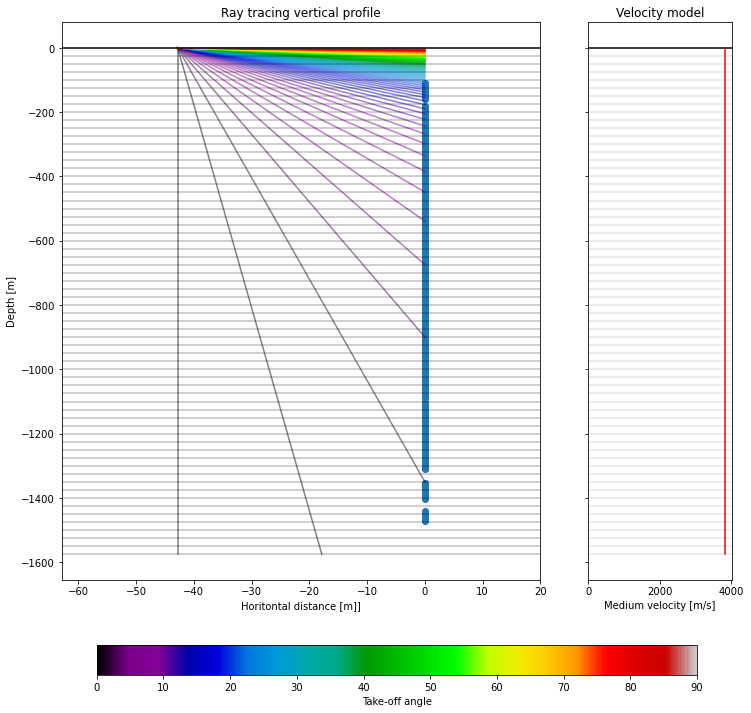

In [19]:
angles = numpy.linspace(0, 89.9, 100)

_ = physics.plot_rays(
    angles,
    velocities,
    keep_upgoing=True,
    domain_x_axis_margin=20,
    force_aspect=False,
)

In [20]:
# %%time
# angles, traveltimes, lt = physics.search_angles(velocities,angles=200,verbose=True)

In [21]:
# %%time
# angles, traveltimes_synthetic,_ = physics.search_angles(velocities,angles=angles,verbose=True)

In [22]:
# _ = physics.plot_rays(
#     angles,
#     velocities,
#     domain_x_axis_margin=20,
#     force_aspect=False,
#     vlims=[3700,3900]
# )

In [23]:
traveltimes_synthetic = physics.forward(velocities)
physics.traveltimes_observed = arrival_times_observed
physics.misfit(velocities)
gradient = physics.gradient(velocities)

Found: 556 / 556 receivers.
Found: 556 / 556 receivers.


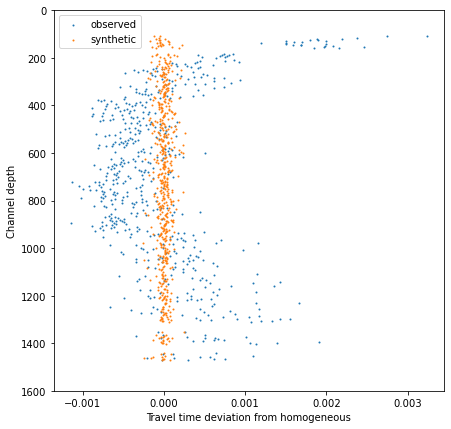

In [28]:

plt.figure(figsize=(7,7))
tta = arrival_times_observed-approximate_origin_time - receiver_distances/approximate_speed 
ttb = traveltimes_synthetic - receiver_distances/approximate_speed
ttb += (tta - ttb).mean()
plt.scatter(tta, physics.receiver_depths, s=1, label="observed")
plt.scatter(ttb, physics.receiver_depths, s=1, label="synthetic")
plt.gca().yaxis
plt.ylim([0,1600])
plt.xlabel("Travel time deviation from homogeneous")
plt.ylabel("Channel depth")
plt.gca().invert_yaxis()
plt.legend()


In [25]:
import hmclab

prior = hmclab.Distributions.Uniform(numpy.ones((physics.dimensions,1)) * 3000,numpy.ones((physics.dimensions)) * 4000)

sampler = hmclab.Samplers.HMC()
post= hmclab.Distributions.BayesRule([prior,physics])
sampler.sample("simple.h5", post,autotuning=True, overwrite_existing_file=True, initial_model=velocities)

Found: 556 / 556 receivers.
 

Tot. acc rate: 0.00. Progress:   0%|                    | 0/100 [00:00<?, ?it/s]

Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 receivers.
Found: 556 / 556 rec

In [29]:
samples = sampler.load_results()

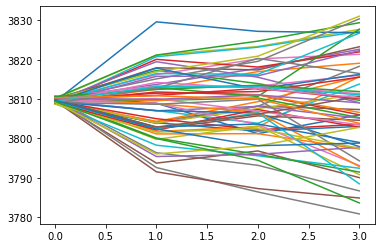

In [32]:
_ = plt.plot(samples[:-1,].T)

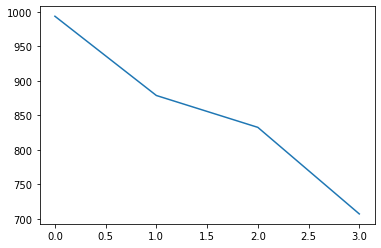

In [33]:
_ = plt.plot(samples[-1,])